In [33]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import warnings
warnings.filterwarnings("ignore")

In [34]:
df = pd.read_pickle(r"E:/final_final.pkl")

In [35]:
dfb = df[df.dataset == 'bench']
dfc = df[df.dataset == 'cuad']

In [36]:
dfb[['type_chunk', 'len_chunk', 'stride', 'embedder']] = dfb.file.apply(lambda x: x.split('/')[-1][:-16]).str.split('_', expand=True)

In [42]:
dfb.len_chunk = pd.to_numeric(dfb.len_chunk)
dfb.stride = pd.to_numeric(dfb.stride)

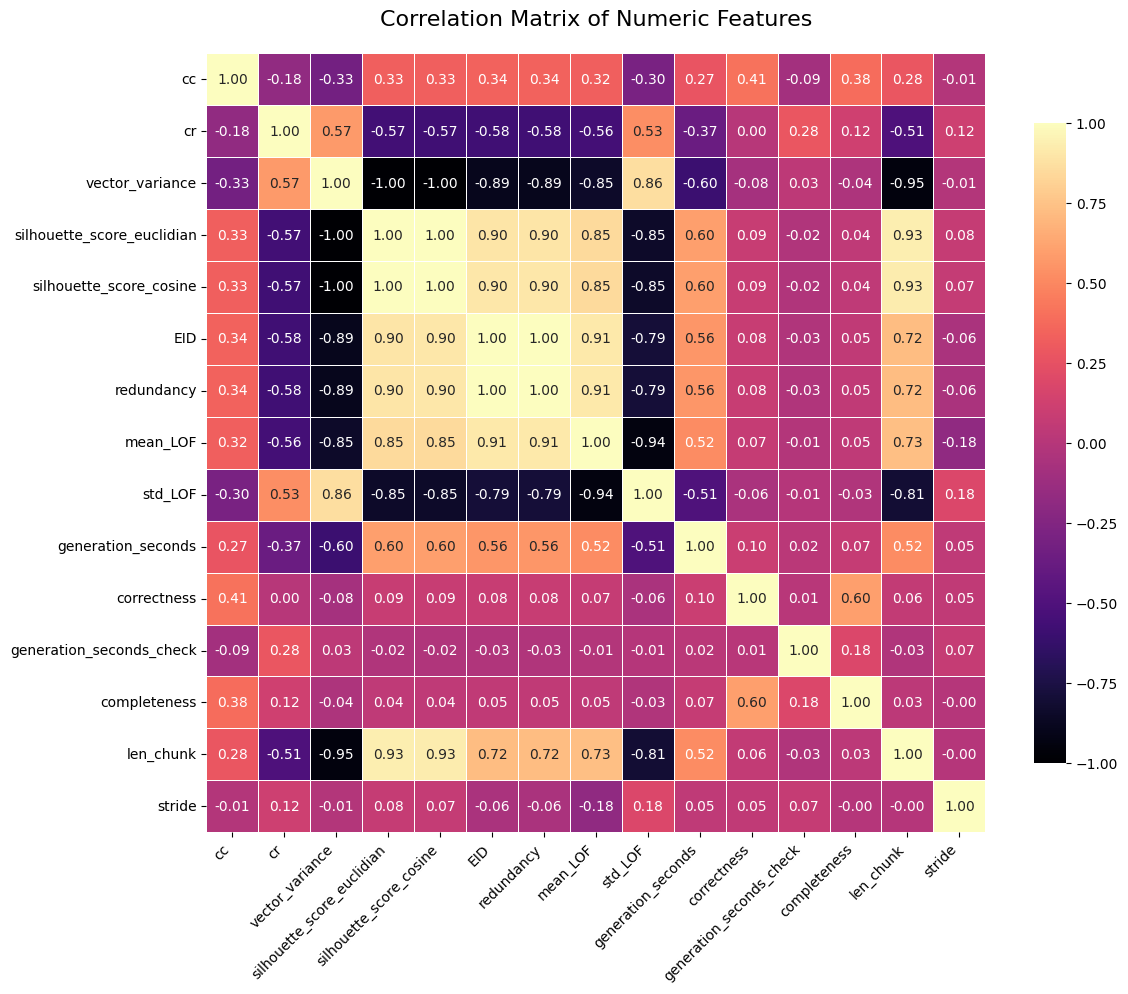

In [48]:
def plot_correlation_matrix(df):
    """
    Plot a beautiful correlation matrix for all numeric columns in a DataFrame.
    
    Parameters:
        df (pd.DataFrame): Input dataframe containing numeric columns
    """
    # Calculate correlation matrix for numeric columns only
    numeric_df = df.select_dtypes(include=[np.number])
    corr = numeric_df.corr()
    
    # Set up the matplotlib figure
    plt.figure(figsize=(12, 10))
    
    # Generate a mask for the upper triangle
    mask = np.triu(np.ones_like(corr, dtype=bool))
    
    # Create heatmap with magma colormap
    sns.heatmap(corr, 
                # mask=mask,
                cmap='magma',
                vmin=-1, vmax=1,
                center=0,
                annot=True,
                fmt='.2f',
                linewidths=0.5,
                cbar_kws={'shrink': 0.8},
                square=True)
    
    # Add title and adjust layout
    plt.title('Correlation Matrix of Numeric Features', 
              fontsize=16, pad=20)
    plt.xticks(rotation=45, ha='right', fontsize=10)
    plt.yticks(fontsize=10)
    
    # Make the plot tight
    plt.tight_layout()
    
    # Show the plot
    plt.show()

# Example usage:
# plot_correlation_matrix(final[final['file'].str.contains('DeepPavlov')])
plot_correlation_matrix(dfb[(dfb.type_chunk=='S') & (dfb.embedder == 'BAAI')])

In [ ]:
import pandas as pd
from optbinning import OptimalBinning
from tqdm import tqdm

def calculate_information_value(df, target_column, features=None, min_bin_size=0.05):
    # Check target is binary
    if df[target_column].nunique() != 2:
        raise ValueError("Target column must be binary (0/1)")
        
    # Prepare features list
    if features is None:
        features = [col for col in df.columns if col != target_column]
    else:
        features = [f for f in features if f != target_column]

    results = []
    
    for feature in tqdm(features):
        X = df[feature]
        y = df[target_column]
        
        # Determine variable type
        dtype = 'categorical' if X.dtype in ['object', 'category', 'bool'] else 'numerical'
        
        try:
            # Initialize and fit optimal binning
            optb = OptimalBinning(
                name=feature,
                dtype=dtype
            )
            optb.fit(X, y)
            optb.binning_table.build()
            
            # Get IV and store results
            iv = optb.binning_table.iv
            results.append({
                'Feature': feature,
                'IV': iv,
                'Variable_Type': dtype.capitalize()
            })
            
        except Exception as e:
            print(f"Could not calculate IV for {feature}: {str(e)}")
            results.append({
                'Feature': feature,
                'IV': None,
                'Variable_Type': dtype.capitalize()
            })
    
    # Create and sort results DataFrame
    iv_df = pd.DataFrame(results)
    iv_df = iv_df.sort_values(by='IV', ascending=False).reset_index(drop=True)
    
    return iv_df

In [76]:
# from optbinning import OptimalBinning

# # Fit OptimalBinning
# optb = OptimalBinning(name='tt', dtype="numerical", solver="cp")
# optb.fit(df.cc, df.correctness)

# # Build the binning table
# table = optb.binning_table.build()

# # Get the Information Value (IV)
# iv = optb.binning_table.iv
# print("Information Value (IV):", iv)

,question_id,relevance,cc,cr,doc,vector_variance,silhouette_score_euclidian,silhouette_score_cosine,EID,redundancy,LOFs,mean_LOF,std_LOF,dataset,generation_seconds,correctness,generation_seconds_check
0,0,"[0.8789534359179991, 0.21243054658224578, 0.44...",0.943662,0.037388,ФАП-29.txt,0.404626,0.094661,0.168449,2.0,0.001953,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",0.996198,0.087121,bench,2.485582,1,5.107615
1,1,"[0.8924310333943564, 0.2664468121089125, 0.178...",0.945205,0.037602,ФАП-29.txt,0.404626,0.094661,0.168449,2.0,0.001953,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",0.996198,0.087121,bench,1.156361,1,4.146044
2,2,"[0.7207845917523338, 0.26856425938994744, 0.19...",0.871795,0.036500,ФАП-29.txt,0.404626,0.094661,0.168449,2.0,0.001953,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",0.996198,0.087121,bench,16.794213,0,5.072578
3,3,"[0.9312045690550363, 0.1902587519025875, 0.329...",0.962963,0.027426,ФАП-29.txt,0.404626,0.094661,0.168449,2.0,0.001953,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",0.996198,0.087121,bench,20.817367,1,3.901685
4,4,"[0.9049133969600566, 0.21088763097675542, 0.14...",0.971014,0.039739,ФАП-29.txt,0.404626,0.094661,0.168449,2.0,0.001953,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",0.996198,0.087121,bench,8.882403,1,3.036051
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19195,75,"[0.4987212276214834, 0.33175803402646503, 0.32...",0.608696,0.033735,ZONDWINDSYSTEMPARTNERSLTDSERIES85-B_04_03_2006...,0.502830,0.068817,0.122479,2.0,0.001953,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",0.999490,0.031940,cuad,3.567019,0,29.914603
19196,76,"[1.0, 0.22289766970618033, 0.9999999999999999,...",0.515152,0.269841,TUNIUCORP_03_06_2014-EX-10-COOPERATION AGREEME...,0.502830,0.068817,0.122479,2.0,0.001953,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",0.999490,0.031940,cuad,3.144258,1,18.953421
19197,77,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]",1.000000,0.000000,ZONDWINDSYSTEMPARTNERSLTDSERIES85-B_04_03_2006...,0.502830,0.068817,0.122479,2.0,0.001953,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",0.999490,0.031940,cuad,3.240590,0,23.960107
19198,78,"[0.7889554224883566, 0.21625416886080392, 0.18...",0.694805,0.201507,IGENEBIOTECHNOLOGYINC_05_13_2003-EX-1-JOINT VE...,0.502830,0.068817,0.122479,2.0,0.001953,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",0.999490,0.031940,cuad,3.674458,1,21.475838


In [87]:
iv_df = dfb.drop(['file', 'texts', 'rel_sent', 'response', 'question', 'llm_answer', 'completeness', 'question_id', 'relevance'], axis=1)
iv_table = calculate_information_value(
    df=iv_df,
    target_column='correctness',
    min_bin_size=0.1
)

iv_table

 22%|██▏       | 4/18 [00:00<00:00, 14.40it/s]

Could not calculate IV for doc: All categories moved to others' bin. Al least one category is needed to perform binning.


 72%|███████▏  | 13/18 [00:00<00:00, 18.87it/s]

Could not calculate IV for LOFs: All categories moved to others' bin. Al least one category is needed to perform binning.


100%|██████████| 18/18 [00:00<00:00, 19.07it/s]

Could not calculate IV for type_chunk: All categories moved to others' bin. Al least one category is needed to perform binning.
Could not calculate IV for embedder: All categories moved to others' bin. Al least one category is needed to perform binning.


,Feature,IV,Variable_Type
0,cc,2.345740,Numerical
1,redundancy,0.893354,Numerical
2,generation_seconds_check,0.705718,Numerical
3,silhouette_score_cosine,0.497607,Numerical
4,vector_variance,0.493901,Numerical
5,silhouette_score_euclidian,0.457654,Numerical
6,cr,0.141776,Numerical
7,generation_seconds,0.097871,Numerical
8,mean_LOF,0.039096,Numerical
9,std_LOF,0.039096,Numerical


In [86]:
dfc

,file,question_id,texts,rel_sent,relevance,cc,cr,doc,question,response,...,redundancy,LOFs,mean_LOF,std_LOF,dataset,llm_answer,generation_seconds,correctness,generation_seconds_check,completeness
9600,E:/indexes2/0_W_128_0.1_intfloat_l2.mirage_index,0,[(2) years from the Effective Date...,8.1 The Company may renew this Agreem...,"[0.08123791102514506, 0.16964285714285712, 0.2...",0.583333,0.055666,WOMENSGOLFUNLIMITEDINC_03_29_2000-EX-10.13-END...,What is the notice period required to terminat...,"According to Section 8.1 of the agreement, the...",...,0.005204,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",0.99908,0.042894,cuad,The notice period required to terminate renewa...,1.019766,1,5.257973,5.0
9601,E:/indexes2/0_W_128_0.1_intfloat_l2.mirage_index,1,"[as set forth in Articles 7.1, 7.2, 8.1 and 8....",,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]",1.000000,0.000000,OLDAPIWIND-DOWNLTD_01_08_2016-EX-1.3-AGENCY AG...,Is there a clause granting one party an “enter...,"No, there is no clause in the provided context...",...,0.005204,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",0.99908,0.042894,cuad,"No, there is no clause granting one party an “...",0.833539,1,8.425774,7.0
9602,E:/indexes2/0_W_128_0.1_intfloat_l2.mirage_index,2,"[2, this Section 10 will not be deemed to prev...",Confidentiality 8.1 Confidential Information 8...,"[0.25576468269609776, 0.2981422165278667, 0.49...",0.357542,0.136170,ZogenixInc_20190509_10-Q_EX-10.2_11663313_EX-1...,Is there a requirement on a party not to dispa...,"No, there does not appear to be a specific req...",...,0.005204,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",0.99908,0.042894,cuad,I don't know the answer. There is no informati...,0.617353,0,13.824882,3.0
9603,E:/indexes2/0_W_128_0.1_intfloat_l2.mirage_index,3,[from the SENDER. \n\n\n CLAUSE TWENTIETH...,License Grants 7.1. Playboy Content. During...,"[0.20185868525351922, 0.2519703845235252, 0.19...",0.279621,0.120163,PlayboyEnterprisesInc_20090220_10-QA_EX-10.2_4...,Does the contract contain a license granted by...,"Yes, the contract contains multiple license gr...",...,0.005204,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",0.99908,0.042894,cuad,"Based on the provided documents, I do not know...",0.675534,0,5.622453,0.0
9604,E:/indexes2/0_W_128_0.1_intfloat_l2.mirage_index,4,"[intention to terminate the Contract, indicati...",Exhibit 10.1 MASTER FRANCHISE AGREEMENT This M...,"[0.03496503496503497, 0.08975012748597655, 0.0...",0.297297,0.040590,SimplicityEsportsGamingCompany_20181130_8-K_EX...,The date when the contract is effective,"According to the agreement, the Effective Date...",...,0.005204,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",0.99908,0.042894,cuad,"To answer your question, I need to know which ...",0.902790,1,19.438297,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19195,E:/indexes2/9_W_128_0.5_BAAI_l2.mirage_index,75,[and duration of the event(s) causing the fail...,Except as expressly modified by Section 1 of t...,"[0.4987212276214834, 0.33175803402646503, 0.32...",0.608696,0.033735,ZONDWINDSYSTEMPARTNERSLTDSERIES85-B_04_03_2006...,Does one party have the right to terminate or ...,Based on the context provided in the First Ame...,...,0.001953,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",0.99949,0.031940,cuad,"Based on the provided documents, I can find in...",3.567019,0,29.914603,0.0
19196,E:/indexes2/9_W_128_0.5_BAAI_l2.mirage_index,76,[operation of thecooperative business to the e...,"(1) Nanjing Tuniu Technology Co., Ltd., with i...","[1.0, 0.22289766970618033, 0.9999999999999999,...",0.515152,0.269841,TUNIUCORP_03_06_2014-EX-10-COOPERATION AGREEME...,Is there a restriction on the ability of a par...,Based on the context provided in the Cooperati...,...,0.001953,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",0.99949,0.031940,cuad,"Based on the provided documents, there are res...",3.144258,1,18.953421,7.0
19197,E:/indexes2/9_W_128_0.5_BAAI_l